### **LIBRARY**

In [ ]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import Input, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

import tensorflow_hub as hub

### **IMPORT DATA**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Getting names of the classes we have
data_directory = pathlib.Path('/content/drive/MyDrive/DEEP LEARNING/test')
class_names = [item.name for item in data_directory.glob('*')][:2]
print(class_names)

['not_pizza', 'pizza']


In [ ]:
pizza_dir = '/content/drive/MyDrive/DEEP LEARNING/train/pizza'
not_pizza_dir = '/content/drive/MyDrive/DEEP LEARNING/train/not_pizza'
data_dir = '/content/drive/MyDrive/DEEP LEARNING/train'

In [ ]:
pizza_dir

'/content/drive/MyDrive/DEEP LEARNING/train/pizza'

In [ ]:
num_pizza_images = len(os.listdir(pizza_dir))
non_pizza_images = len(os.listdir(not_pizza_dir))
print(f'Number of Pizza images: {num_pizza_images}')
print(f'Number of Non-Pizza images: {non_pizza_images}')

Number of Pizza images: 800
Number of Non-Pizza images: 800


### **VISUALISASI IMAGE**

In [ ]:
# Defining data generator withour Data Augmentation
data_gen = ImageDataGenerator(rescale = 1/255., validation_split = 0.2)

train_data = data_gen.flow_from_directory(data_dir,
                                          target_size = (224, 224),
                                          batch_size = 32,
                                          subset = 'training',
                                          class_mode = 'binary')
val_data = data_gen.flow_from_directory(data_dir,
                                        target_size = (224, 224),
                                        batch_size = 32,
                                        subset = 'validation',
                                        class_mode = 'binary')

Found 1280 images belonging to 2 classes.
Found 320 images belonging to 2 classes.


In [ ]:
# Mengambil satu batch data pelatihan dari generator data
images, labels = train_data.next()
len(images), len(labels), images[0].shape

(32, 32, (224, 224, 3))

In [ ]:
def plot_random_images():
    """
    Plots 20 Random Images from the dataset
    """

    images, labels = train_data.next()
    labels = labels.astype('int32')
    i = 1

    plt.figure(figsize = (10, 5))

    for image, label in zip(images, labels):
        plt.subplot(4, 5, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
        i += 1
        if i == 21:
            break

    plt.tight_layout()
    plt.show()

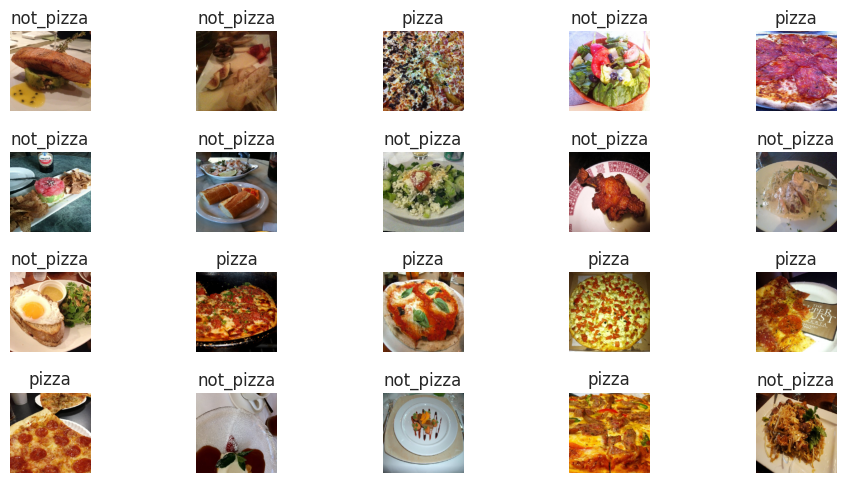

In [ ]:
plot_random_images()

# **BASELINE MODEL**

Pertama, dibuat baseline model tanpa menggunakan data augmentasi dan tidak menambahkan max pooling layer

In [ ]:
tf.random.set_seed(42)
model_1 = Sequential([
    Input(shape = (224, 224, 3)), # Input layer
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'), # First Convolutional layer
    Conv2D(filters = 64, kernel_size = 2, padding = 'valid', activation = 'relu'), # Second Convolutional layer
    Flatten(),
    Dense(1, activation = 'sigmoid') # Output layer
])

model_1.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(),
                metrics = ['accuracy'])

history_1 = model_1.fit(train_data,
                        epochs= 5,
                        steps_per_epoch = len(train_data),
                        validation_data = val_data,
                        validation_steps = len(val_data))

Epoch 1/5
40/40 [==============================] - 369s 9s/step - loss: 3.6725 - accuracy: 0.5797 - val_loss: 0.6746 - val_accuracy: 0.6000
Epoch 2/5
40/40 [==============================] - 7s 182ms/step - loss: 0.5260 - accuracy: 0.7531 - val_loss: 0.5306 - val_accuracy: 0.7219
Epoch 3/5
40/40 [==============================] - 7s 172ms/step - loss: 0.2810 - accuracy: 0.8984 - val_loss: 0.5806 - val_accuracy: 0.7312
Epoch 4/5
40/40 [==============================] - 8s 202ms/step - loss: 0.1255 - accuracy: 0.9695 - val_loss: 0.5683 - val_accuracy: 0.7125
Epoch 5/5
40/40 [==============================] - 7s 168ms/step - loss: 0.0375 - accuracy: 0.9977 - val_loss: 0.9314 - val_accuracy: 0.6969


In [ ]:
# Plot the validation and training data separately
def plot_loss_curves(history):
    """
    Plots the curves of both loss and accuracy
    """

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(loss))

    fig, ax = plt.subplots(1, 2, figsize = (20, 5))

    # Plotting loss
    ax1 = sns.lineplot(x = epochs, y = loss, label='Training Loss', ax= ax[0])
    ax1 = sns.lineplot(x = epochs, y = val_loss, label='Validation Loss', ax= ax[0])
    ax1.set(title = 'Loss', xlabel = 'Epochs')

    # Plot accuracy
    ax2 = sns.lineplot(x = epochs, y = accuracy, label='Training Accuracy', ax= ax[1])
    ax2 = sns.lineplot(x = epochs, y = val_accuracy, label='Validation Accuracy', ax=ax[1])
    ax2.set(title = 'Accuracy', xlabel = 'Epochs')

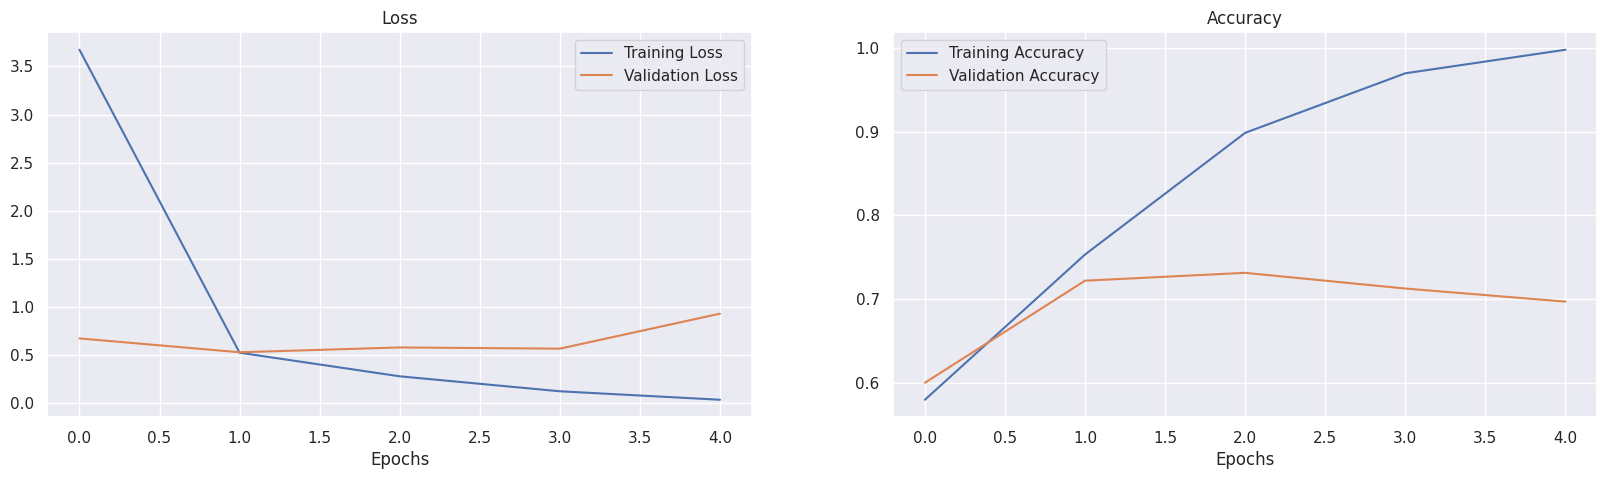

In [ ]:
plot_loss_curves(history_1)

### **MAX POOLING LAYER**

Dilakukan penambahan max pooling layer

In [ ]:
model_2 = Sequential([
    Input(shape = (224, 224, 3)),
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'), MaxPool2D(pool_size = 2),
    Conv2D(filters = 64, kernel_size = 2, padding = 'valid', activation = 'relu'), MaxPool2D(pool_size = 2),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])

model_2.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(),
                metrics = ['accuracy'])

history_2 = model_2.fit(train_data,
                        epochs= 5,
                        steps_per_epoch = len(train_data),
                        validation_data = val_data,
                        validation_steps = len(val_data))

Epoch 1/5
40/40 [==============================] - 9s 172ms/step - loss: 0.8364 - accuracy: 0.5641 - val_loss: 0.6505 - val_accuracy: 0.6062
Epoch 2/5
40/40 [==============================] - 8s 207ms/step - loss: 0.5831 - accuracy: 0.7086 - val_loss: 0.5978 - val_accuracy: 0.6781
Epoch 3/5
40/40 [==============================] - 7s 165ms/step - loss: 0.4757 - accuracy: 0.7820 - val_loss: 0.6576 - val_accuracy: 0.6000
Epoch 4/5
40/40 [==============================] - 8s 199ms/step - loss: 0.3823 - accuracy: 0.8500 - val_loss: 0.5535 - val_accuracy: 0.7281
Epoch 5/5
40/40 [==============================] - 7s 171ms/step - loss: 0.2664 - accuracy: 0.9070 - val_loss: 0.6260 - val_accuracy: 0.7312


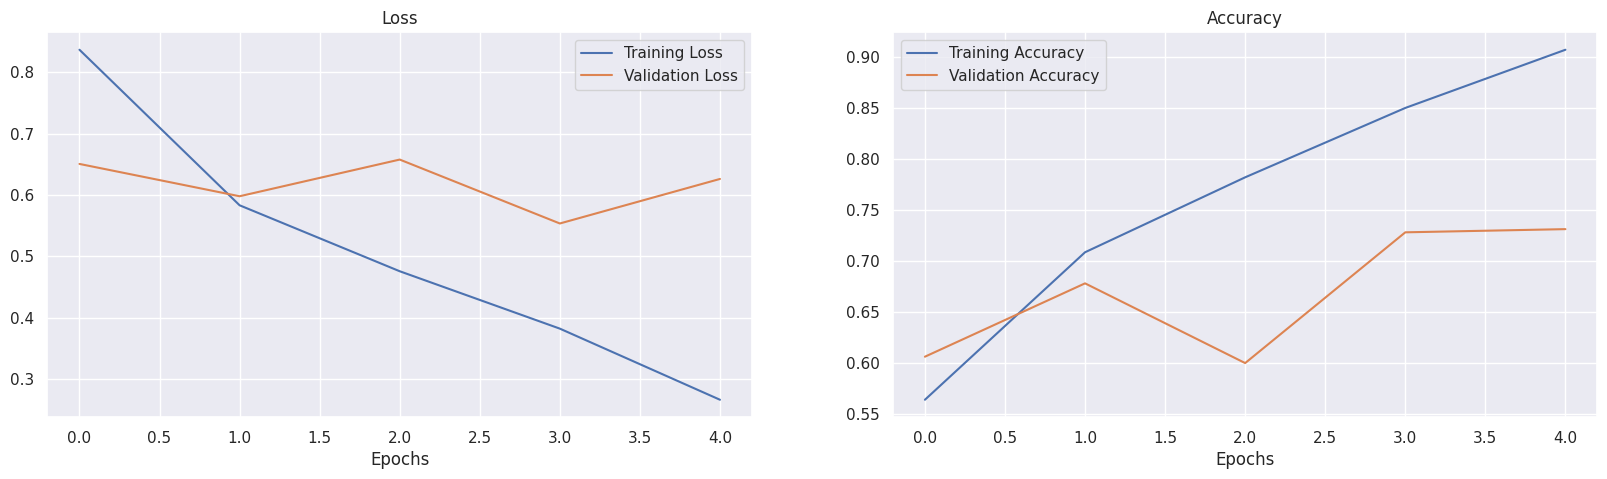

In [ ]:
plot_loss_curves(history_2)

### **DATA AUGMENTATION**

In [ ]:
data_gen_augmented = ImageDataGenerator(rescale = 1/255.,
                                        validation_split = 0.2,
                                        zoom_range = 0.2,
                                        horizontal_flip= True,
                                        rotation_range = 20,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2)

print('Augmented training Images:')
train_data_augmented = data_gen_augmented.flow_from_directory(data_dir,
                                                              target_size = (224, 224),
                                                              batch_size = 32,
                                                              subset = 'training',
                                                              class_mode = 'binary')
print('Unchanged Validation Images:')
val_data = data_gen.flow_from_directory(data_dir,
                                        target_size = (224, 224),
                                        batch_size = 32,
                                        subset = 'validation',
                                        class_mode = 'binary')

Augmented training Images:
Found 1280 images belonging to 2 classes.
Unchanged Validation Images:
Found 320 images belonging to 2 classes.


In [ ]:
model_3 = Sequential([
    Input(shape = (224, 224, 3)),
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'), MaxPool2D(pool_size = 2),
    Conv2D(filters = 64, kernel_size = 2, padding = 'valid', activation = 'relu'), MaxPool2D(pool_size = 2),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])

model_3.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(),
                metrics = ['accuracy'])

history_3 = model_3.fit(train_data_augmented,
                        epochs= 5,
                        steps_per_epoch = len(train_data),
                        validation_data = val_data,
                        validation_steps = len(val_data))

Epoch 1/5
40/40 [==============================] - 24s 549ms/step - loss: 0.8211 - accuracy: 0.5695 - val_loss: 0.6410 - val_accuracy: 0.6531
Epoch 2/5
40/40 [==============================] - 23s 574ms/step - loss: 0.6352 - accuracy: 0.6406 - val_loss: 0.6057 - val_accuracy: 0.6562
Epoch 3/5
40/40 [==============================] - 24s 595ms/step - loss: 0.6086 - accuracy: 0.6680 - val_loss: 0.5891 - val_accuracy: 0.6906
Epoch 4/5
40/40 [==============================] - 24s 597ms/step - loss: 0.5993 - accuracy: 0.6953 - val_loss: 0.5333 - val_accuracy: 0.7500
Epoch 5/5
40/40 [==============================] - 24s 590ms/step - loss: 0.5632 - accuracy: 0.7063 - val_loss: 0.5015 - val_accuracy: 0.7563


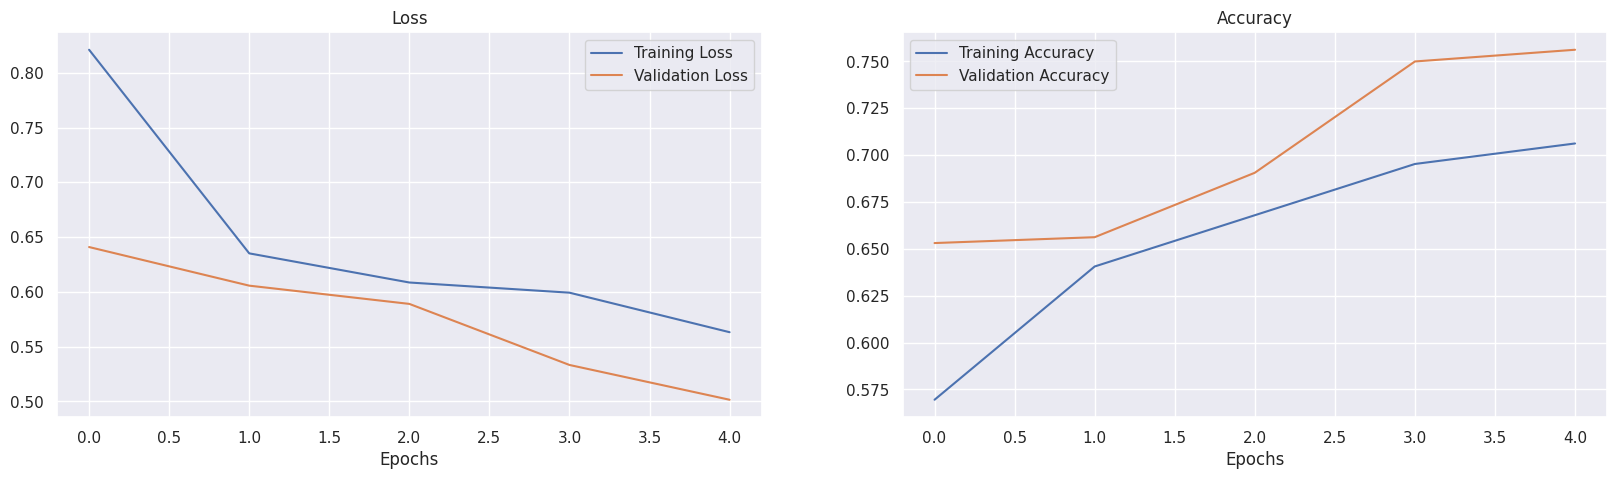

In [ ]:
plot_loss_curves(history_3)

### **IMPROVING MODEL**

Beberapa hal yang dilakukan dalam improving model adalah:
1. Menambahkan epochs
2. Mengubah angka filter
3. Penambahan convolutional layers

In [ ]:
model_4 = Sequential([
    Input(shape = (224, 224, 3)),
    Conv2D(filters = 10, kernel_size = 2, padding = 'valid', activation = 'relu'), MaxPool2D(pool_size = 2),
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'), MaxPool2D(pool_size = 2),
    Conv2D(filters = 64, kernel_size = 2, padding = 'valid', activation = 'relu'), MaxPool2D(pool_size = 2),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])

model_4.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(learning_rate = 0.0001),
                metrics = ['accuracy'])

history_4 = model_4.fit(train_data_augmented,
                        epochs= 10,
                        steps_per_epoch = len(train_data),
                        validation_data = val_data,
                        validation_steps = len(val_data))

Epoch 1/10
40/40 [==============================] - 26s 580ms/step - loss: 0.6806 - accuracy: 0.5797 - val_loss: 0.6532 - val_accuracy: 0.6656
Epoch 2/10
40/40 [==============================] - 22s 539ms/step - loss: 0.6534 - accuracy: 0.6109 - val_loss: 0.6419 - val_accuracy: 0.6125
Epoch 3/10
40/40 [==============================] - 22s 564ms/step - loss: 0.6390 - accuracy: 0.6477 - val_loss: 0.6135 - val_accuracy: 0.6906
Epoch 4/10
40/40 [==============================] - 22s 555ms/step - loss: 0.6189 - accuracy: 0.6578 - val_loss: 0.6083 - val_accuracy: 0.6719
Epoch 5/10
40/40 [==============================] - 23s 574ms/step - loss: 0.6168 - accuracy: 0.6625 - val_loss: 0.5944 - val_accuracy: 0.6969
Epoch 6/10
40/40 [==============================] - 23s 576ms/step - loss: 0.6037 - accuracy: 0.6641 - val_loss: 0.5970 - val_accuracy: 0.7281
Epoch 7/10
40/40 [==============================] - 23s 584ms/step - loss: 0.5947 - accuracy: 0.6711 - val_loss: 0.6255 - val_accuracy: 0.6031

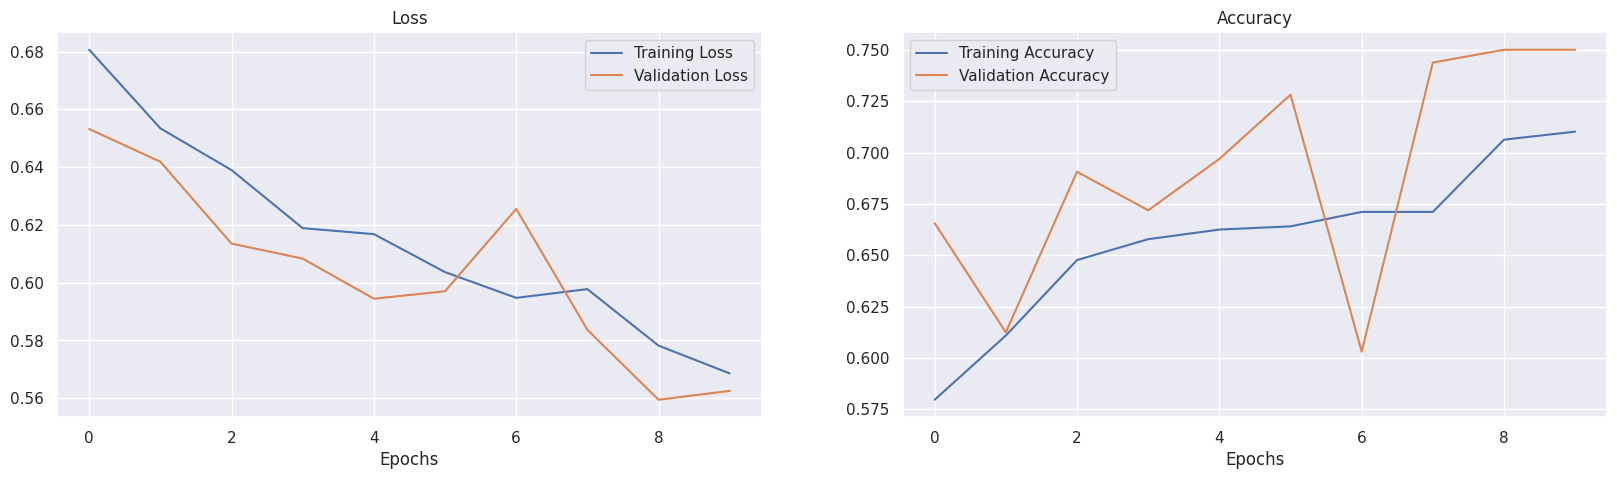

In [ ]:
plot_loss_curves(history_4)

### **TRANSFER LEARNING**

In [ ]:
# EfficientNetB7 feature vector
url = 'https://tfhub.dev/google/efficientnet/b7/feature-vector/1'

feature_extractor_layer = hub.KerasLayer(url,
                                         trainable=False,
                                         input_shape=(224, 224, 3))

model_5 = Sequential([
    feature_extractor_layer,
    Dense(1, activation = 'sigmoid')
])

model_5.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(),
                metrics = ['accuracy'])

history_5 = model_5.fit(train_data,
                        epochs= 5,
                        steps_per_epoch = len(train_data),
                        validation_data = val_data,
                        validation_steps = len(val_data))

Epoch 1/5
40/40 [==============================] - 35s 497ms/step - loss: 0.2707 - accuracy: 0.9273 - val_loss: 0.1483 - val_accuracy: 0.9594
Epoch 2/5
40/40 [==============================] - 17s 431ms/step - loss: 0.1213 - accuracy: 0.9609 - val_loss: 0.1206 - val_accuracy: 0.9656
Epoch 3/5
40/40 [==============================] - 18s 438ms/step - loss: 0.0976 - accuracy: 0.9664 - val_loss: 0.1109 - val_accuracy: 0.9688
Epoch 4/5
40/40 [==============================] - 18s 437ms/step - loss: 0.0852 - accuracy: 0.9703 - val_loss: 0.1056 - val_accuracy: 0.9688
Epoch 5/5
40/40 [==============================] - 17s 433ms/step - loss: 0.0757 - accuracy: 0.9727 - val_loss: 0.0994 - val_accuracy: 0.9719


In [ ]:
test_loss, test_acc = model_5.evaluate(val_data)

print(f"test accuracy : {round(test_acc * 100)}%")

10/10 [==============================] - 4s 347ms/step - loss: 0.0994 - accuracy: 0.9719
test accuracy : 97%


In [ ]:
from tensorflow.keras.models import save_model
save_model(model_1,'model1.h5')

In [ ]:
save_model(model_2,'model2.h5')

In [ ]:
save_model(model_3,'model3.h5')

In [ ]:
save_model(model_4,'model4.h5')

In [ ]:
save_model(model_5,'model5.h5')